# Recommendation engine based on FunkSVD

This is a simple recommendation engine that recommends movies to users based on movie reviews data supplied by [Udacity](https://www.udacity.com/) in the [data scientist nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025) course.

It uses a blend of the "FunkSVD" matrix factorization technique (made famous by [Simon Funk](https://sifter.org/simon/journal/20061211.html) in the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize) competition) as well as content and knowledge-based recommendations for users/movies that are not contained in the training FunkSVD training data (e.g. because they are new users and/or movies).

While currently the `Recommender` class is implemented such that it works best with the Udacity dataset, it is easy to implement for other datasets as well.

As a first step, we create an instance of the `Recommender` class, specifying the `csv` files containing movie and user reviews data.

In [1]:
from recommender import Recommender
import numpy as np
import os
import json

rec = Recommender("movies_clean.csv", "reviews_clean.csv")

We then run the fit. Alternatively, we can decide to load results from a previously conducted fit.

In [2]:
# Whether to run the fit or restore previous fit results
#
# Note that for udacity-provided dataset and using default values, FunkSVD
# only takes around 1 minute to fit on a modern-era CPU
load_from_checkpoint = False

if load_from_checkpoint:
    # load results from current directory
    rec.load_results("./")
    
    print("Successfully loaded results!")
else:
    # fit recommender
    rec.fit()
    
    # after fit, store results for being able to load them later

    np.save("u_mat.npy", rec.u_mat)
    np.save("i_mat.npy", rec.i_mat)

    res_dict = {
        "iterations": 100,
        "latent_feats": 12,
        "train_size": 8000,
        "learning_rate": 0.001,
        "test_size": 2000,
        "order_by": "date",
        "seed": None,
        "u_mat": os.path.abspath("./u_mat.npy"),
        "i_mat": os.path.abspath("./i_mat.npy")
    }

    with open("results.json", "w") as jsonfile:
        json.dump(res_dict, jsonfile, indent=4)

Optimization
Iterations | Mean Squared Error
1 		 18.265115949206795
2 		 12.762054431869226
3 		 10.342004023153546
4 		 8.935375164104022
5 		 7.961116942277914
6 		 7.216776661790408
7 		 6.6163979373134625
8 		 6.115846576574696
9 		 5.6889693322084085
10 		 5.318726814234579
11 		 4.993306116114691
12 		 4.704160255237466
13 		 4.4449077763793206
14 		 4.210665239044069
15 		 3.997619141027074
16 		 3.8027399902463332
17 		 3.6235852335013528
18 		 3.45815989195901
19 		 3.304815811006888
20 		 3.1621774048314175
21 		 3.0290859865697763
22 		 2.904557398849962
23 		 2.7877493357095955
24 		 2.677935840856372
25 		 2.5744871958461077
26 		 2.4768539067984925
27 		 2.384553841297077
28 		 2.297161809377656
29 		 2.214301056685122
30 		 2.135636265158737
31 		 2.06086775095128
32 		 1.989726620070261
33 		 1.921970695858752
34 		 1.857381073373235
35 		 1.795759187138903
36 		 1.736924302960393
37 		 1.6807113631263613
38 		 1.6269691287338826
39 		 1.5755585739366524
40 		 1.526351

During the fit, we see the iterations as well as the mean squared error (MSE) after each iteration being printed out. In our example, we achieve an MSE value of around 0.37 (actual value might differ depending on random initialization) after the final iteration.

Finally, we evaluate our results on a statistically independent validation dataset and plot a visualization of the confusion matrix of the ratings (ranging from values of 1 to 10 here).

As we can see, at least for the highly populated rating values, we get predictions around the diagonal. However, it is more difficult to make an assessment for lower ratings, since there is much less statistics available.

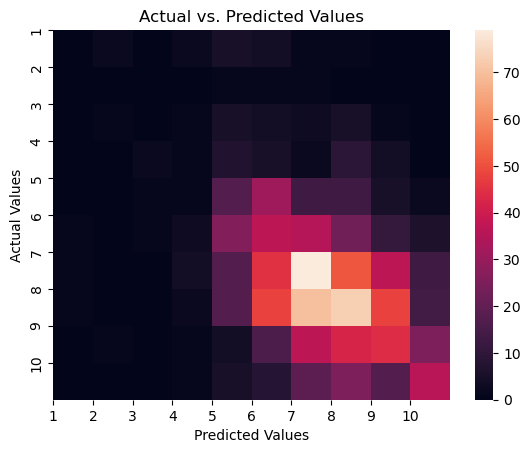

In [3]:
val_results = rec.validation_comparison(plot=True)

Let's also print the root mean squared error (RMSE) for the validation dataset, as well as the percentage of values that could be rated by FunkSVD:

In [4]:
print(val_results["rmse"], val_results["perc_rated"])

1.866806072988112 0.5475


We see that on the validation set, the RMSE is way higher than for the training set (the corresponding value for the MSE of 0.37 that was achieved by the training set would be around 0.6).

Also, the `perc_rated` value in the `val_results` dictionary tells us that only around 54% of values were actually able to receive a rating. The rest of the validation set consists of movies or users that did not exist in the training set, and thus `FunkSVD` can't make a prediction here. 

The difficulty of inferring ratings/recommendations for **new** items/users is known as the "cold start problem". For these users/items we need to resort to content/knowledge based recommendations instead, which will later be done using the `make_recs` method of our `Recommender`.

We can see what happens when we try to predict a rating for a made-up user ID, that doesn't exist in the training set:

In [6]:
# if either a movie or a user is not in our training data, we can't make a
# prediction with our trained FunkSVD model and a ValueError is raised
pred = rec.predict_rating(5211, 1663662)

ValueError: User or movie is not in training data and thus no prediction can be made

We throw a `ValueError` here and print out the respective error prompt.

Finally, we create a result dictionary (`res_dict`), that contains 5 recommendations for **all** users in our validation dataset:

Users that **do** exist in the training set receive recommendations based on `FunkSVD` while **other** users get knowledge/content based recommendations. In the latter case, recommendations are based on the **average** rating of a movie, the **number** of ratings a movie received and the **recency** of movie ratings, sorted in this order. The number 5 was arbitrarily chosen here, and can be set to a different value by changing the `rec_num` variable in the `make_recs` method.

In [7]:
# create dictionary with user id's and recommendations
res_dict = {}
for usr in rec.val_df["user_id"]:
    res_dict[usr] = rec.make_recs(usr, id_type="user")

Let's print the recommendations for two of the users as an example

In [14]:
print(res_dict[rec.val_df["user_id"].iloc[0]])
print(res_dict[rec.val_df["user_id"].iloc[-1]])

['The Magnificent Seven (1960)', 'Il buono, il brutto, il cattivo (1966)', 'Immortal Beloved (1994)', 'Life of Pi (2012)', 'Star Trek Into Darkness (2013)']
['A Beautiful Mind (2001)', 'National Treasure (2004)', 'Star Trek Into Darkness (2013)', 'Jodaeiye Nader az Simin (2011)', 'The Sessions (2012)']
